In [8]:
import numpy as np
import os
import tensorflow as tf
import librosa
import time
import tensorflow_datasets as tfds
import librosa.display
import matplotlib.pyplot as plt
from tqdm import tqdm
!pip install tensorflow_io
import tensorflow_io as tfio
from scipy.io import wavfile
!pip install pydub
from pydub import AudioSegment
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# Download Dataset #
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download kongaevans/speaker-recognition-dataset
! unzip speaker-recognition-dataset.zip
! rm speaker-recognition-dataset.zip

In [65]:
# get wav paths
data_dir1 = "/content/16000_pcm_speeches"
def get_wav_paths(speaker, data_dir):
    speaker_path = os.path.join(data_dir,speaker)
    all_paths = [os.path.join(speaker_path,item) for item in os.listdir(speaker_path)]
    return all_paths

speaker_dict = {}

# Dataset from kaggle
for speaker in (os.listdir(data_dir1)):
  if speaker[0].isupper() :
      speaker_dict[speaker] = get_wav_paths(speaker, data_dir1)

# Add my own dataset from google drive
speaker_dict["Natapol"] = get_wav_paths("Natapol", "/content/drive/MyDrive/Voice_Dataset/Nattapol_Dataset" )
speaker_dict["Thitima"] = get_wav_paths("Thitima", "/content/drive/MyDrive/Voice_Dataset/Thitima_Dataset" )

noise1_paths = get_wav_paths("_background_noise_", data_dir1)
noise2_paths = get_wav_paths("other", data_dir1)
print(speaker_dict["Natapol"])
print(list(speaker_dict))

['/content/drive/MyDrive/Voice_Dataset/Nattapol_Dataset/Natapol/858.wav', '/content/drive/MyDrive/Voice_Dataset/Nattapol_Dataset/Natapol/903.wav', '/content/drive/MyDrive/Voice_Dataset/Nattapol_Dataset/Natapol/927.wav', '/content/drive/MyDrive/Voice_Dataset/Nattapol_Dataset/Natapol/862.wav', '/content/drive/MyDrive/Voice_Dataset/Nattapol_Dataset/Natapol/991.wav', '/content/drive/MyDrive/Voice_Dataset/Nattapol_Dataset/Natapol/897.wav', '/content/drive/MyDrive/Voice_Dataset/Nattapol_Dataset/Natapol/932.wav', '/content/drive/MyDrive/Voice_Dataset/Nattapol_Dataset/Natapol/918.wav', '/content/drive/MyDrive/Voice_Dataset/Nattapol_Dataset/Natapol/988.wav', '/content/drive/MyDrive/Voice_Dataset/Nattapol_Dataset/Natapol/883.wav', '/content/drive/MyDrive/Voice_Dataset/Nattapol_Dataset/Natapol/870.wav', '/content/drive/MyDrive/Voice_Dataset/Nattapol_Dataset/Natapol/981.wav', '/content/drive/MyDrive/Voice_Dataset/Nattapol_Dataset/Natapol/865.wav', '/content/drive/MyDrive/Voice_Dataset/Nattapol_Dat

In [66]:
# load the data 
def load_wav(wav_path):
    if wav_path[-3:] != "wav" :
      audiofile = AudioSegment.from_file(wav_path)
      signal = np.array(audiofile.get_array_of_samples())
      fs = audiofile.frame_rate
      wav_path = "wav_file.wav"
      wavfile.write(wav_path, fs, signal)

    wav_data, sr = librosa.load(wav_path,sr=16000)
    return wav_data
# create training data
def generate_training_data(speaker_paths, speaker, label):
    wavs, labels = [], []
    count = 0
    for wav_path in tqdm(speaker_paths):
        wav = load_wav(wav_path)
        if wav is not None :
          wavs.append(wav)
          labels.append(label)
          count +=1
        if count == 1501:
          break
    return wavs, labels
all_wavs = []
all_labels = []
for i, speaker in enumerate(speaker_dict) :
  print(speaker)
  wav, label = generate_training_data(speaker_dict[speaker], speaker, i)
  all_wavs += wav
  all_labels += label

Nelson_Mandela


100%|██████████| 1500/1500 [00:00<00:00, 4819.42it/s]


Julia_Gillard


100%|█████████▉| 1500/1501 [00:00<00:00, 5375.38it/s]


Benjamin_Netanyau


100%|██████████| 1500/1500 [00:00<00:00, 4923.27it/s]


Jens_Stoltenberg


100%|██████████| 1500/1500 [00:00<00:00, 5141.96it/s]


Magaret_Tarcher


100%|██████████| 1500/1500 [00:00<00:00, 5585.92it/s]


Natapol


 80%|███████▉  | 1500/1884 [00:57<00:14, 25.90it/s]


Thitima


 86%|████████▋ | 1500/1735 [00:02<00:00, 624.87it/s]


(16000,)
(10503,)


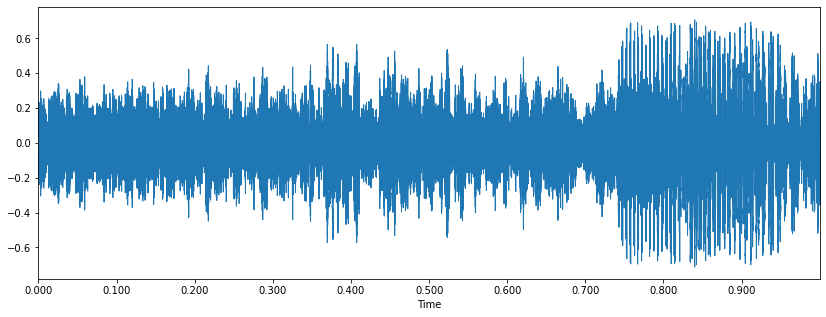

In [68]:
# Chech if the library is correct
print(np.shape(all_wavs[1]))
print(np.shape(all_labels))

plt.figure(figsize=(14, 5))
librosa.display.waveplot(all_wavs[100],sr=16000)

# import matplotlib.pyplot as plt
# # Example of audio data #
# audio_data = "/content/drive/MyDrive/Voice_Dataset/Thitima_Dataset/Thitima/1004.wav"
# x , sr = librosa.load(audio_data)
# plt.figure(figsize=(14, 5))
# plt.title('Signal')
# librosa.display.waveplot(x, sr=sr)

In [76]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

train_wavs, test_wavs, train_labels, test_labels = train_test_split(all_wavs, all_labels, test_size=0.3, random_state = 42)
test_labels = to_categorical(test_labels, dtype ="uint8")
train_labels = to_categorical(train_labels, dtype ="uint8")

print(test_labels.shape)
print(test_labels[1])
print(np.shape(train_wavs))
print(np.shape(test_wavs))

(3151, 7)
[0 0 0 0 0 1 0]
(7352,)
(3151, 16000)


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


In [77]:
# MFCC Feature Extraction

train_wavs_mfcc = []

for i,sample in enumerate(train_wavs):
    if np.shape(sample) == (16000,):
      mfcc = librosa.feature.mfcc(y=np.array(sample,dtype="float32"), sr=sr,hop_length=128, n_fft=256, n_mfcc=20)
      mfcc_delta = librosa.feature.delta(mfcc)
      mfcc_double_delta = librosa.feature.delta(mfcc, order=2)
      mfcc = np.concatenate((mfcc,mfcc_delta,mfcc_double_delta),axis=0)
      train_wavs_mfcc.append(mfcc.T)
    else : train_labels = np.delete(train_labels,i,axis=0)

test_wavs_mfcc = []

for i,sample in enumerate(test_wavs):
    if np.shape(sample) == (16000,):
      mfcc = librosa.feature.mfcc(y=np.array(sample,dtype="float32"), sr=sr,hop_length=128, n_fft=256, n_mfcc=20)
      mfcc_delta = librosa.feature.delta(mfcc)
      mfcc_double_delta = librosa.feature.delta(mfcc, order=2)
      mfcc = np.concatenate((mfcc,mfcc_delta,mfcc_double_delta),axis=0)
      test_wavs_mfcc.append(mfcc.T)
    else : test_labels = np.delete(test_labels,i,axis=0)

train_wavs_mfcc = np.expand_dims(train_wavs_mfcc,axis=3)
test_wavs_mfcc = np.expand_dims(test_wavs_mfcc,axis=3)
print(np.shape(train_wavs_mfcc))


/usr/local/lib/python3.7/dist-packages/librosa/filters.py:239: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  "Empty filters detected in mel frequency basis. "


(7349, 126, 60, 1)


In [78]:
print(np.shape(train_wavs_mfcc[0]))
print(train_labels.shape)

(126, 60, 1)
(7349, 7)


In [79]:
def cnn_modelv1() :
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(128, (3, 3), activation="relu", input_shape = np.shape(train_wavs_mfcc[0])))
    model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Conv2D(64, (3, 3), activation="relu"))
    # model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))

    model.add(tf.keras.layers.Flatten())        
    model.add(tf.keras.layers.Dense(test_labels.shape[1], activation="softmax"))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4)
            , loss = "categorical_crossentropy"
            , metrics = ["accuracy"])
    return model
model = cnn_modelv1()
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 124, 58, 128)      1280      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 62, 29, 128)      0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 60, 27, 64)        73792     
                                                                 
 flatten_4 (Flatten)         (None, 103680)            0         
                                                                 
 dense_4 (Dense)             (None, 7)                 725767    
                                                                 
Total params: 800,839
Trainable params: 800,839
Non-trainable params: 0
________________________________________________

In [80]:
history = model.fit(train_wavs_mfcc,train_labels, epochs=5, validation_batch_size=(test_wavs_mfcc,test_labels))

Epoch 1/5
230/230 [==============================] - 199s 861ms/step - loss: 0.7161 - accuracy: 0.8654
Epoch 2/5
230/230 [==============================] - 197s 859ms/step - loss: 0.0616 - accuracy: 0.9816
Epoch 3/5
230/230 [==============================] - 197s 856ms/step - loss: 0.0224 - accuracy: 0.9947
Epoch 4/5
230/230 [==============================] - 197s 856ms/step - loss: 0.0176 - accuracy: 0.9951
Epoch 5/5
230/230 [==============================] - 196s 852ms/step - loss: 0.0299 - accuracy: 0.9918


In [81]:
test_loss, test_acc = model.evaluate(test_wavs_mfcc,  test_labels)

99/99 [==============================] - 20s 201ms/step - loss: 0.0543 - accuracy: 0.9825


In [82]:
def predict_speaker(wav_path) :
  wav_data = load_wav(wav_path)
  mfcc = librosa.feature.mfcc(y=np.array(wav_data,dtype="float32"), sr=sr,hop_length=128, n_fft=256, n_mfcc=20)
  mfcc_delta = librosa.feature.delta(mfcc)
  mfcc_double_delta = librosa.feature.delta(mfcc, order=2)
  mfcc = np.concatenate((mfcc,mfcc_delta,mfcc_double_delta),axis=0)
  mfcc = np.expand_dims(mfcc.T,axis=2)
  mfcc = np.expand_dims(mfcc,axis=0)
  result = model.predict(mfcc)
  max_val = max(result[0])
  max_index = np.where(result[0] == max_val)
  return list(speaker_dict)[max_index[0][0]]

speaker = predict_speaker("/content/drive/MyDrive/Voice_Dataset/Nattapol_Dataset/Natapol/1800.wav")
print(speaker)

Natapol


/usr/local/lib/python3.7/dist-packages/librosa/filters.py:239: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  "Empty filters detected in mel frequency basis. "


In [85]:
model.save("mfccDelta_model_multi.h5")